## Transfer learning

Now, a common misconception in the DL community is that without a Google-esque amount of data, you can’t possibly hope to create effective deep learning models. While data is a critical part of creating the network, the idea of transfer learning has helped to lessen the data demands. Transfer learning is the process of taking a pre-trained model (the weights and parameters of a network that has been trained on a large dataset by somebody else) and “fine-tuning” the model with your own dataset. The idea is that this pre-trained model will act as a feature extractor. You will remove the last layer of the network and replace it with your own classifier (depending on what your problem space is). You then freeze the weights of all the other layers and train the network normally (Freezing the layers means not changing the weights during gradient descent/optimization).

Let’s investigate why this works. Let’s say the pre-trained model that we’re talking about was trained on ImageNet (Remember the famous dataset that started the CNN hype and contains 14 million images with over 1,000 classes). When we think about the lower layers of the network, we know that they will detect features like edges and curves. Now, unless you have a very unique problem space and dataset, your network is going to need to detect curves and edges as well. Rather than training the whole network through a random initialization of weights, we can use the weights of the pre-trained model (and freeze them) and focus on the more important layers (ones that are higher up) for training. If your dataset is quite different than something like ImageNet, then you’d want to train more of your layers and freeze only a couple of the low layers.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

### Dataset:
In this tutorial we will be working with the cats and dogs dataset - and as the name says - it contains images of cats and dogs that we want to classify accordingly (--> binary classification problem). 

NOTE: The 2,000 images used in this tutorial are excerpted from the "Dogs vs. Cats" dataset available on Kaggle, which contains 25,000 images. Here, we use a subset of the full dataset to decrease training time for educational purposes.

<img src="ai.jpg" alt="ai" width="200"/>

In [5]:
### Downloading the images
#The contents of the .zip are extracted to the base directory /tmp/cats_and_dogs_filtered,
#which contains train and validation subdirectories for the training and validation datasets

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)


validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)


Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Let's visualise some examples from the dataset:

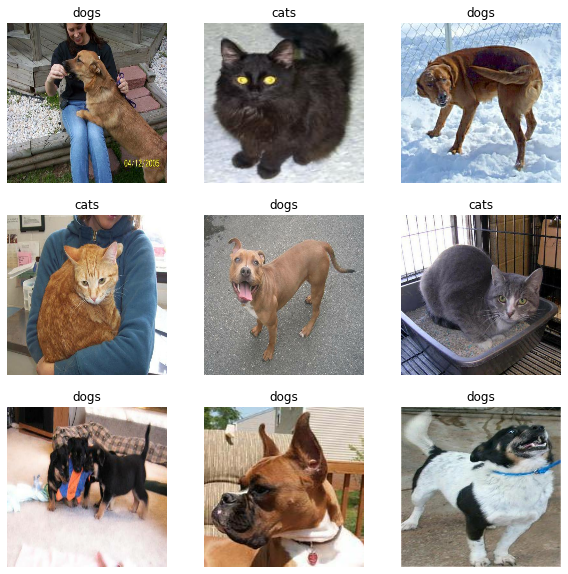

In [6]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

As the original dataset doesn't contains a test set, you will create one. To do so, determine how many batches of data are available in the validation set using ```tf.data.experimental.cardinality```, then move 20% of them to a test set.

In [28]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


### MobileNet

You will create the base model from the MobileNet V2 model developed at Google. This is pre-trained on the ImageNet dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [8]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [9]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


### Feature extraction

In this step, you will freeze the convolutional base created from the previous step and to use as a feature extractor. Additionally, you add a classifier on top of it and train the top-level classifier.

It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting layer.trainable = False) prevents the weights in a given layer from being updated during training. MobileNet has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [14]:
base_model.trainable = False

#### Add a classification head

To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a ```tf.keras.layers.GlobalAveragePooling2D``` layer to convert the features to a single 1280-element vector per image.

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a ```tf.keras.layers.Dense``` layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.

In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In a moment, you will download tf.keras.applications.MobileNetV2 for use as your base model. This model expects pixel vaues in [-1,1], but at this point, the pixel values in your images are in [0-255]. To rescale them, use the preprocessing method included with the model.

In [17]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [20]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

#### Compile the model

Compile the model before training it. Since there are two classes, use a binary cross-entropy loss with from_logits=True since the model provides a linear output.

In [21]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281  

The 2.5M parameters in MobileNet are frozen, but there are 1.2K trainable parameters in the Dense layer. These are divided between two tf.Variable objects, the weights and biases.

In [23]:
len(model.trainable_variables)

2

In [22]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

32/32 [==============================] - 14s 358ms/step - loss: 0.8325 - accuracy: 0.4373


In [24]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.84
initial accuracy: 0.45


In [25]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 38s 563ms/step - loss: 0.7029 - accuracy: 0.5620 - val_loss: 0.5459 - val_accuracy: 0.6660
Epoch 2/10
63/63 [==============================] - 37s 588ms/step - loss: 0.4883 - accuracy: 0.7300 - val_loss: 0.3748 - val_accuracy: 0.8230
Epoch 3/10
63/63 [==============================] - 37s 589ms/step - loss: 0.3431 - accuracy: 0.8390 - val_loss: 0.2818 - val_accuracy: 0.8870
Epoch 4/10
63/63 [==============================] - 38s 592ms/step - loss: 0.2665 - accuracy: 0.8875 - val_loss: 0.2257 - val_accuracy: 0.9260
Epoch 5/10
63/63 [==============================] - 37s 579ms/step - loss: 0.2142 - accuracy: 0.9225 - val_loss: 0.1904 - val_accuracy: 0.9380
Epoch 6/10
63/63 [==============================] - 36s 570ms/step - loss: 0.1877 - accuracy: 0.9350 - val_loss: 0.1656 - val_accuracy: 0.9450
Epoch 7/10
63/63 [==============================] - 32s 504ms/step - loss: 0.1660 - accuracy: 0.9425 - val_loss: 0.1472 - val_accuracy: 0.9570

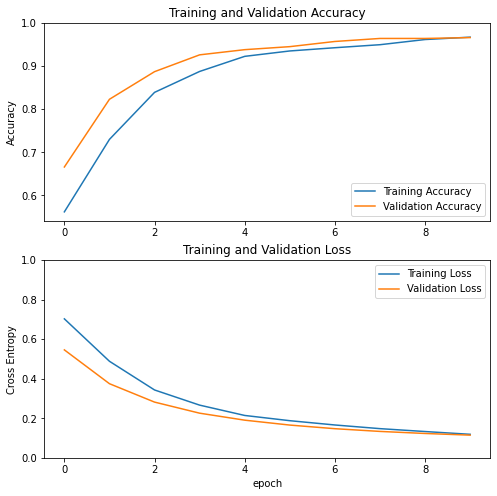

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [29]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 2s 304ms/step - loss: 0.1123 - accuracy: 0.9583
Test accuracy : 0.9583333134651184


Predictions:
 [0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0]
Labels:
 [0 0 0 1 0 1 1 1 1 0 0 0 1 1 0 1 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0]


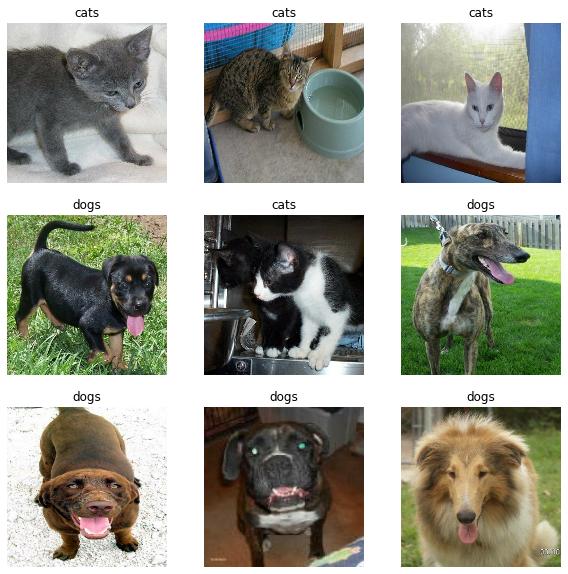

In [30]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

#### Fine-tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNet V2 base model. The weights of the pre-trained network were not updated during training.
One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.

In [31]:
#Un-freeze the top layers of the model
#All you need to do is unfreeze the base_model and set the bottom layers to be un-trainable. 
#Then, you should recompile the model (necessary for these changes to take effect), and resume training.

base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  154


In [32]:
#Compile the model
#As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower learning rate at this stage. 
#Otherwise, your model could overfit very quickly.

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281  

In [33]:
#This time we have more trainable variables
len(model.trainable_variables)

56

In [34]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 55s 824ms/step - loss: 0.0663 - accuracy: 0.9834 - val_loss: 0.0459 - val_accuracy: 0.9827
Epoch 11/20
63/63 [==============================] - 54s 851ms/step - loss: 0.0215 - accuracy: 0.9961 - val_loss: 0.0514 - val_accuracy: 0.9802
Epoch 12/20
63/63 [==============================] - 47s 746ms/step - loss: 0.0161 - accuracy: 0.9911 - val_loss: 0.0470 - val_accuracy: 0.9839
Epoch 13/20
63/63 [==============================] - 42s 673ms/step - loss: 0.0092 - accuracy: 0.9979 - val_loss: 0.0509 - val_accuracy: 0.9827
Epoch 14/20
63/63 [==============================] - 43s 677ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.0389 - val_accuracy: 0.9876
Epoch 15/20
63/63 [==============================] - 43s 677ms/step - loss: 0.0061 - accuracy: 0.9978 - val_loss: 0.0702 - val_accuracy: 0.9827
Epoch 16/20
63/63 [==============================] - 43s 675ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0482 - val_accuracy:

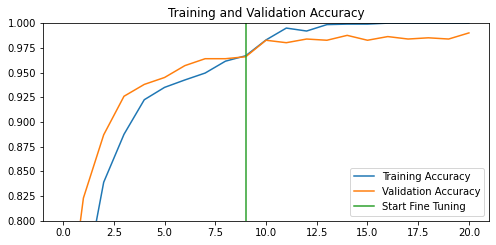

In [35]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

#loss += history_fine.history['loss']
#val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

#plt.subplot(2, 1, 2)
#plt.plot(loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss')
#plt.ylim([0, 1.0])
#plt.plot([initial_epochs-1,initial_epochs-1],
         #plt.ylim(), label='Start Fine Tuning')
#plt.legend(loc='upper right')
#plt.title('Training and Validation Loss')
#plt.xlabel('epoch')
plt.show()

In [36]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 2s 344ms/step - loss: 0.2057 - accuracy: 0.9688
Test accuracy : 0.96875


Predictions:
 [0 1 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 1 1]
Labels:
 [0 1 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 1 1]


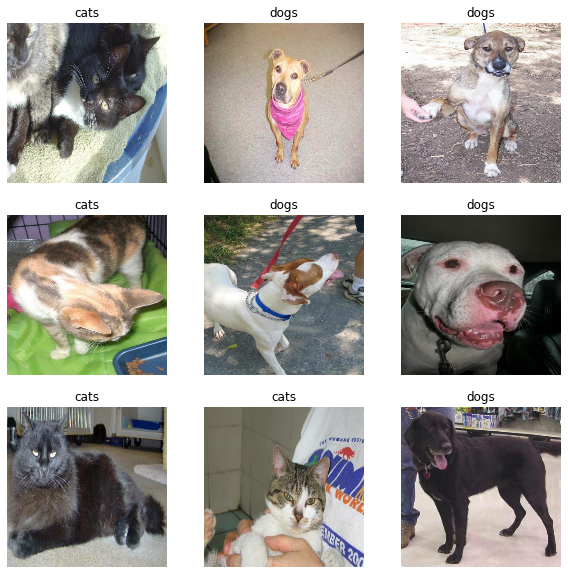

In [37]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

#### References:
- https://ruder.io/transfer-learning/
- https://cs231n.github.io/transfer-learning/